In [ ]:
import csv
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
from tensorflow import keras
# import the necessary packages
from collections import namedtuple
import numpy as np
import cv2
# define the `Detection` object for IOU(
Detection = namedtuple("Detection", ["image_path", "gt", "pred"])
from PIL import Image, ImageOps
# importing XML parsing library for parsing the data
import xml.etree.ElementTree as ET
from collections import namedtuple


In [ ]:
from google.colab import drive
data_images = '/content/drive/MyDrive/oxford-iiit-pet/images/images'
data_ClassList = '/content/drive/MyDrive/oxford-iiit-pet/annotations/annotations/list.txt'
data_xmlAnnotations = '/content/drive/MyDrive/oxford-iiit-pet/annotations/annotations/xmls'
TARGET_SIZE = (224, 224)

In [ ]:
#BoundingBox
Bounding_Box = namedtuple('Bounding_Box', 'xmin ymin xmax ymax')
# The following function will read the xml and return the values for xmin, ymin, xmax, ymax for formulating the bounding box
def building_bounding_box(path_to_xml_annotation):
  tree = ET.parse(path_to_xml_annotation)
  root = tree.getroot()
  path_to_box = './object/bndbox/'
  xmin = int(root.find(path_to_box + "xmin").text)
  ymin = int(root.find(path_to_box + "ymin").text)
  xmax = int(root.find(path_to_box + "xmax").text)
  ymax = int(root.find(path_to_box + "ymax").text)
  return Bounding_Box(xmin, ymin, xmax, ymax)

In [ ]:
def resize_image_with_bounds(path_to_image, bounding_box=None, target_size=None):
  image = Image.open(path_to_image)
  width, height = image.size
  w_pad = 0
  h_pad = 0
  bonus_h_pad = 0
  bonus_w_pad = 0
  #the following code helps determining where to pad or is it not necessary for the images we have.
  # If the difference between the width and height was odd((height<width)case), we add one pixel on one side
  # If the difference between the height and width was odd((height>width)case), then we add one pixel on one side.
  #if both of these are not the case, then pads=0, no padding is needed, since the image is already a square itself.
  if width > height:
    pix_diff = (width - height)
    h_pad = pix_diff // 2
    bonus_h_pad = pix_diff % 2
  elif height > width:
    pix_diff = (height - width)
    w_pad = pix_diff // 2
    bonus_w_pad = pix_diff % 2
  # When we pad the image to square, we need to adjust all the bounding box values by the amounts we added on the left or top.
  #The "bonus" pads are always done on the bottom and right so we can ignore them in terms of the box.
  image = ImageOps.expand(image, (w_pad, h_pad, w_pad+bonus_w_pad, h_pad+bonus_h_pad))
  if bounding_box is not None:
    new_xmin = bounding_box.xmin + w_pad
    new_xmax = bounding_box.xmax + w_pad
    new_ymin = bounding_box.ymin + h_pad
    new_ymax = bounding_box.ymax + h_pad
  # We need to also apply the scalr to the bounding box which we used in resizing the image
  if target_size is not None:
  # So, width and height have changed due to the padding resize.
    width, height = image.size
    image = image.resize(target_size)
    width_scale = target_size[0] / width
    height_scale = target_size[1] / height
  if bounding_box is not None:
    new_xmin = new_xmin * width_scale
    new_xmax = new_xmax * width_scale
    new_ymin = new_ymin * height_scale
    new_ymax = new_ymax * height_scale
  image_data = np.array(image.getdata()).reshape(image.size[0], image.size[1], 3)
  # The image data is a 3D array such that 3 channels ,RGB of target_size.(RGB values are 0-255)
  if bounding_box is None:
    return image_data, None
  return (image_data, Bounding_Box(new_xmin, new_ymin, new_xmax, new_ymax))

In [ ]:
def setting_sample_from_name(sample_name):
  path_to_image = os.path.join(data_images, sample_name + '.jpg')
  path_to_xml = os.path.join(data_xmlAnnotations, sample_name + '.xml')
  original_bounding_box = building_bounding_box(path_to_xml)
  image_data, bounding_box = resize_image_with_bounds(path_to_image, original_bounding_box, TARGET_SIZE)
  return (image_data, bounding_box)

In [ ]:
data_pros = []
with open(data_ClassList) as csv_list_file:
  csv_reader = csv.reader(csv_list_file, delimiter=' ')
  for row in csv_reader:
    if row[0].startswith('#'): continue
  # Unpack for readability
    sample_name, class_id, species, breed_id = row
  # Not every image has a bounding box, some files are missing.So, lets ignore those by the following lines
    try:
      image, bounding_box = setting_sample_from_name(sample_name)
    except FileNotFoundError:
    # This actually happens quite a lot, as you can see in the output.
    # we end up with 7349 samples.
      print(f'cannot find annotations for {sample_name}: so skipped it')
      continue
    # cat = 0 and dog = 1.
    data_tuple = (image, int(species) - 1, bounding_box)
    data_pros.append(data_tuple)
    print(f'Processed {len(data_pros)} samples')
  data_pros = np.array(data_pros)

"data_pros = []\nwith open(data_ClassList) as csv_list_file:\n  csv_reader = csv.reader(csv_list_file, delimiter=' ')\n  for row in csv_reader:\n    if row[0].startswith('#'): continue\n  # Unpack for readability\n    sample_name, class_id, species, breed_id = row\n  # Not every image has a bounding box, some files are missing.So, lets ignore those by the following lines\n    try:\n      image, bounding_box = setting_sample_from_name(sample_name)\n    except FileNotFoundError:\n    # This actually happens quite a lot, as you can see in the output.\n    # we end up with 7349 samples.\n      print(f'cannot find annotations for {sample_name}: so skipped it')\n      continue\n    # cat = 0 and dog = 1.\n    data_tuple = (image, int(species) - 1, bounding_box)\n    data_pros.append(data_tuple)\n    print(f'Processed {len(data_pros)} samples')\n  data_pros = np.array(data_pros)"

In [ ]:
#pet_data_array = np.array(data_pros, dtype=object)
#np.save('/content/drive/MyDrive/oxford-iiit-pet/annotations/annotations/data4.npy', pet_data_array)

In [ ]:
data_pros = np.load('/content/drive/MyDrive/oxford-iiit-pet/annotations/annotations/data4.npy', allow_pickle=True)

In [ ]:
c_dog=0
c_cat=0
x_train = []
y_class_train = []
y_box_train = []
x_validation = []
y_class_validation = []
y_box_validation = []
validation_split = 0.2
for image, species, bounding_box in data_pros:
  if species == 0:
    c_cat+=1
    if c_cat>680:
      continue
  else:
    c_dog += 1
    if c_dog>680:
      continue

  if np.random.random() > validation_split:
    x_train.append(preprocess_input(image))
    y_class_train.append(species)
    y_box_train.append(bounding_box)
  else:
    x_validation.append(preprocess_input(image))
    y_class_validation.append(species)
    y_box_validation.append(bounding_box)
x_train = np.array(x_train)
y_class_train = np.array(y_class_train)
y_box_train = np.array(y_box_train)
x_validation = np.array(x_validation)
y_class_validation = np.array(y_class_validation)
y_box_validation = np.array(y_box_validation)

In [ ]:
from sys import getsizeof
getsizeof(x_train)

654495896

In [ ]:
print(len(x_train)+len(x_validation))


1360


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))
for layer in base_model.layers[:]:
    layer.trainable = False
chopped_resnet1 = Model(inputs=[base_model.input], outputs=[base_model.layers[90].output])
classification_output1 = GlobalAveragePooling2D()(chopped_resnet1.output)
classification_output1 = Dense(units=1, activation='sigmoid')(classification_output1)
localization_output1 = Flatten()(chopped_resnet1.output)
localization_output1 = Dense(units=4, activation='relu')(localization_output1)
model = Model(inputs=[chopped_resnet1.input], outputs=[classification_output1, localization_output1])


94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
model.compile(optimizer='adam', metrics=['accuracy'],loss=['binary_crossentropy', 'mse'],loss_weights=[800, 1]  )
#lets run it through 10 epochs
history2=model.fit(x_train, [y_class_train, y_box_train], validation_data=(x_validation, [y_class_validation, y_box_validation]),epochs=10,verbose=True)
history2

Epoch 1/10
34/34 [==============================] - 15s 132ms/step - loss: 4413.4888 - dense_loss: 0.7180 - dense_1_loss: 3839.1040 - dense_accuracy: 0.5051 - dense_1_accuracy: 0.5897 - val_loss: 3341.5432 - val_dense_loss: 0.6929 - val_dense_1_loss: 2787.1909 - val_dense_accuracy: 0.5165 - val_dense_1_accuracy: 0.4982
Epoch 2/10
34/34 [==============================] - 3s 87ms/step - loss: 3281.8003 - dense_loss: 0.6941 - dense_1_loss: 2726.5500 - dense_accuracy: 0.5041 - dense_1_accuracy: 0.7875 - val_loss: 3171.9297 - val_dense_loss: 0.6789 - val_dense_1_loss: 2628.7915 - val_dense_accuracy: 0.5788 - val_dense_1_accuracy: 0.7985
Epoch 3/10
34/34 [==============================] - 3s 87ms/step - loss: 3240.4158 - dense_loss: 0.6874 - dense_1_loss: 2690.4822 - dense_accuracy: 0.5492 - dense_1_accuracy: 0.7902 - val_loss: 3194.9333 - val_dense_loss: 0.7566 - val_dense_1_loss: 2589.6221 - val_dense_accuracy: 0.4945 - val_dense_1_accuracy: 0.7912
Epoch 4/10
34/34 [=======================

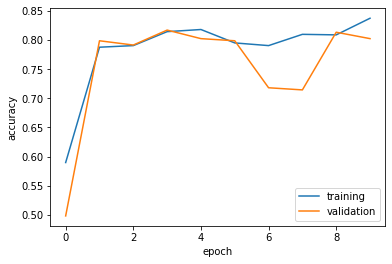

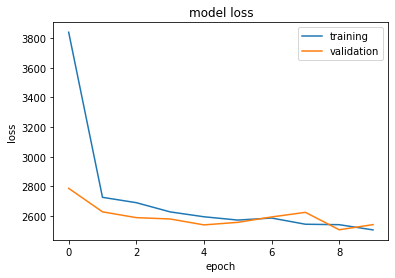

In [ ]:
def plot_training_history(history, model):
  plt.plot(history.history['dense_1_accuracy'])
  plt.plot(history.history['val_dense_1_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['training', 'validation'], loc='best')
  plt.show()
  plt.plot(history.history['dense_1_loss'])
  plt.plot(history.history['val_dense_1_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['training', 'validation'], loc='best')
  plt.show()
plot_training_history(history2, model)

In [ ]:
model.save('/content/drive/MyDrive/oxford-iiit-pet/annotations/annotations/model1.h5')

1/1 [==============================] - 0s 22ms/step
it is a dog by ResNet
intersection of union = 0.20651548405290807


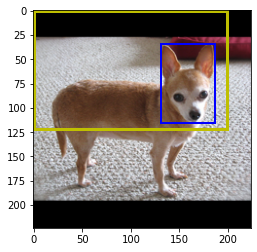

In [ ]:
i = np.random.randint(len(data_pros))
img, species, true_bounding_box = data_pros[i]
pred = model.predict(np.array([preprocess_input(img)]))
if pred[0][0] < .5:
  print("it is a Cat by ResNet")
else:
  print("it is a dog by ResNet")
  plot_with_box(img, Bounding_Box(*pred[1][0]), true_bounding_box)


In [ ]:
def plot_with_box(image_data, bounding_box, compare_box=None):
  fig,ax = plt.subplots(1)
  ax.imshow(image_data)
  # Creating a Rectangle patch for the changed one
  boxA = patches.Rectangle((bounding_box.xmin, bounding_box.ymin),
  bounding_box.xmax - bounding_box.xmin,
  bounding_box.ymax - bounding_box.ymin,
  linewidth=3, edgecolor='y', facecolor='none')
  # Add the patch to the Axes
  ax.add_patch(boxA)
  #Creating another Rectangular patch for the real one
  if compare_box is not None:
    boxB = patches.Rectangle((compare_box.xmin, compare_box.ymin),
    compare_box.xmax - compare_box.xmin,
    compare_box.ymax - compare_box.ymin,
    linewidth=2, edgecolor='b', facecolor='none')
  # Add the patch to the Axes
    ax.add_patch(boxB)
  #FOR FINDING INTERSECTION OVER UNION
    xA = max(bounding_box.xmin, compare_box.xmin)
    yA = max(bounding_box.ymin, compare_box.ymin)
    xB = min(bounding_box.xmax, compare_box.xmax)
    yB = max(bounding_box.ymax, compare_box.ymax)
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (bounding_box.xmax - bounding_box.xmin + 1) * (bounding_box.ymax - bounding_box.ymin + 1)
    boxBArea = (compare_box.xmax - compare_box.xmin + 1) * (compare_box.ymax - compare_box.ymin + 1)
    iou =interArea/float(boxAArea+boxBArea-interArea)
  #By intersection of union I mean intersection over union(IOU) #itself
  print('intersection of union =',iou)
  plt.show()